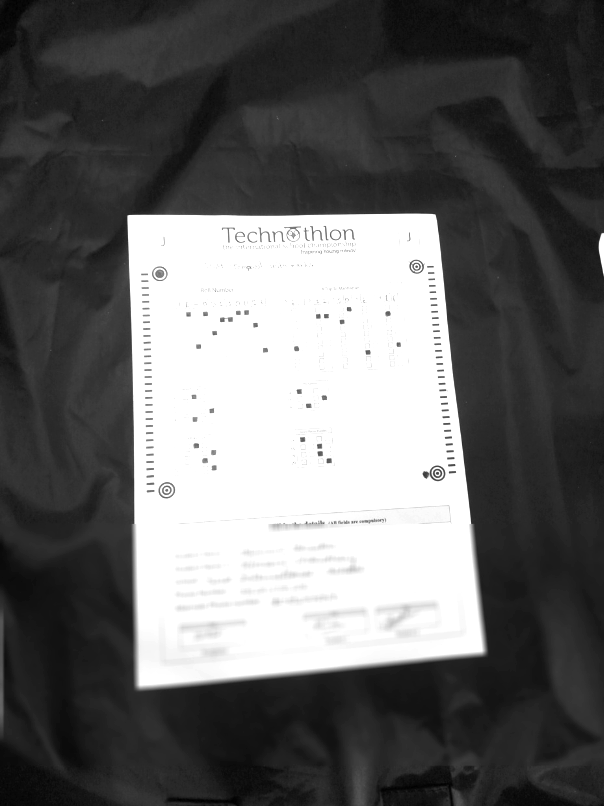

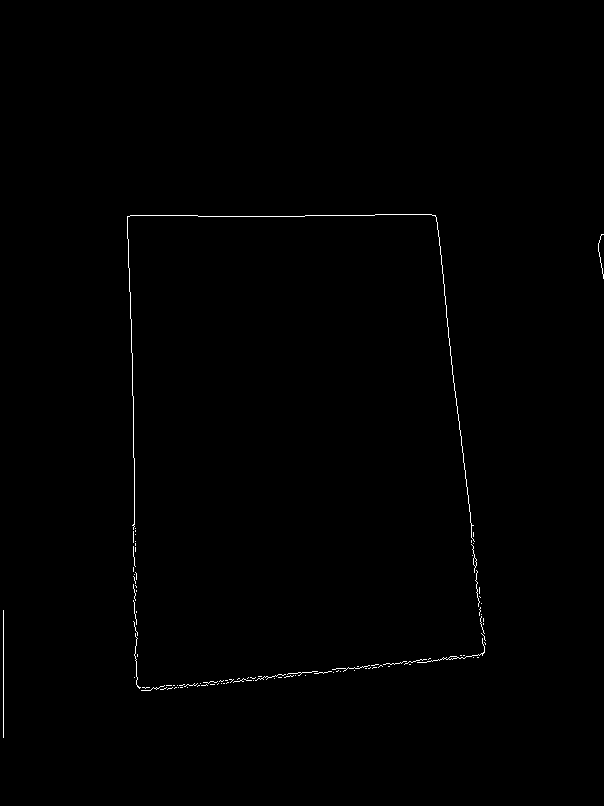

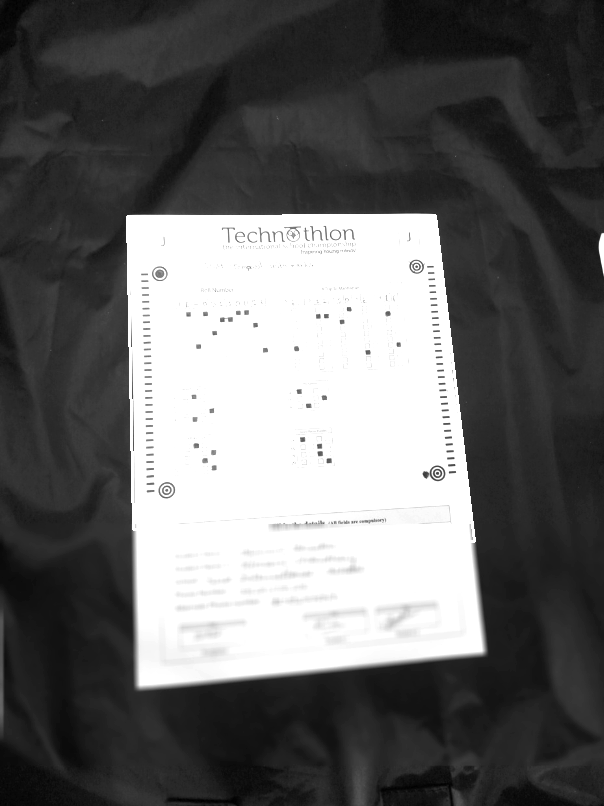

array([[474, 541],
       [133, 529],
       [127, 216],
       [435, 215]], dtype=int32)

In [10]:

import cv2
import numpy as np
from IPython.display import display
from PIL import Image
from matplotlib import pyplot as plt
MIN_PAGE_AREA = 80000
def grab_contours(cnts):
        # source: imutils package

        # if the length the contours tuple returned by cv2.findContours
        # is '2' then we are using either OpenCV v2.4, v4-beta, or
        # v4-official
        if len(cnts) == 2:
            cnts = cnts[0]

        # if the length of the contours tuple is '3' then we are using
        # either OpenCV v3, v4-pre, or v4-alpha
        elif len(cnts) == 3:
            cnts = cnts[1]

        # otherwise OpenCV has changed their cv2.findContours return
        # signature yet again and I have no idea WTH is going on
        else:
            raise Exception(
                (
                    "Contours tuple must have length 2 or 3, "
                    "otherwise OpenCV changed their cv2.findContours return "
                    "signature yet again. Refer to OpenCV's documentation "
                    "in that case"
                )
            )

        # return the actual contours array
        return cnts
def find_page( image):
        # Done: find ORIGIN for the quadrants
        # Done, Auto tune! : Get canny parameters tuned

        image = cv2.normalize(image, 0, 255, norm_type=cv2.NORM_MINMAX)
        # Assumes white pages -
        _ret, image = cv2.threshold(image, 200, 255, cv2.THRESH_TRUNC)
        image =cv2.normalize(image, 0, 255, norm_type=cv2.NORM_MINMAX)

        # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 10))
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 10))

        # Closing is reverse of Opening, Dilation followed by Erosion.
        # A pixel in the original image (either 1 or 0) will be considered 1 only
        # if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).

        # Close the small holes, i.e. Complete the edges on canny image
        closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

        # TODO: Parametrize this from template config
        edge = cv2.Canny(closed, 185, 55)

        # findContours returns outer boundaries in CW and inner boundaries in ACW
        # order.
        cnts = grab_contours(
            cv2.findContours(edge, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        )
        # hullify to resolve disordered curves due to noise
        cnts = [cv2.convexHull(c) for c in cnts]
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
        sheet = []
        for c in cnts:
            if cv2.contourArea(c) < MIN_PAGE_AREA:
                continue
            peri = cv2.arcLength(c, True)
            # ez algo -
            # https://en.wikipedia.org/wiki/Ramer–Douglas–Peucker_algorithm
            approx = cv2.approxPolyDP(c, epsilon=0.025 * peri, closed=True)
            # print("Area",cv2.contourArea(c), "Peri", peri)

            # check its rectangle-ness:
            # if validate_rect(approx)
            if True:
                sheet = np.reshape(approx, (4, -1))
                display(Image.fromarray(image))
                cv2.drawContours(image, [approx], -1, (255,0, 255), 2)
                display(Image.fromarray(edge))
                cv2.drawContours(edge, [approx], -1, (255, 255, 255), 10)
                display(Image.fromarray(image))
                break
        # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # plt.imshow(edge)
        # plt.title('my picture')
        # plt.show()
        
        #cv2.waitKey(0)
            # box = perspective.order_points(box)
        # sobel = cv2.addWeighted(cv2.Sobel(edge, cv2.CV_64F, 1, 0, ksize=3),
        #           0.5,cv2.Sobel(edge, cv2.CV_64F, 0, 1, ksize=3),0.5,0,edge)

        # ExcessDo : make it work on killer images
        # edge2 = auto_canny(image_norm)
        # show('Morphed Edges',np.hstack((closed,edge)),1,1)

        return sheet
# path="samples/sample1/MobileCamera/sheet1.jpg"
# display(Image.open(path))
image =cv2.imread("samples/sample1/MobileCamera/sheet1.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, None, fx = 0.65, fy = 0.65)
find_page( image)